<a href="https://colab.research.google.com/github/dinesh-umkc/kdm/blob/main/ICP3_Text_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Objective
Text classification using 20 news group

Perform below activities
1. Get dataset
2. Preapare Data for classification
3. Feature extraction and explore vectorization
  *  Count vector
  *  TF-IDF vector
  *  Word level TF-IDF
  *  N-Gram level TF-IDF
  *  Character level TF-IDF
  *  Hashing vercor
4. Use of classifiers


In [3]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Load Packages

In [39]:
# load packages
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics,svm
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer,HashingVectorizer
from sklearn import decomposition, ensemble

import numpy as np
import pandas as pd
import csv


# Import 20News Group Dataset

In [11]:
#import dataset
from sklearn.datasets import fetch_20newsgroups
newsgroups = fetch_20newsgroups(subset='all')

trainDF = pd.DataFrame(newsgroups.data, columns=['text'])
trainDF['categories'] = [newsgroups.target_names[index] for index in newsgroups.target]
trainDF=trainDF[:1000]
trainDF.head()
len(trainDF)

1000

In [12]:
trainDF.shape

(1000, 2)

In [13]:
trainDF.columns

Index(['text', 'categories'], dtype='object')

In [6]:
# change datatype to string
trainDF = trainDF[["categories","text"]].astype(str)

In [14]:
# check labels in category
trainDF['categories'].unique()

array(['rec.sport.hockey', 'comp.sys.ibm.pc.hardware',
       'talk.politics.mideast', 'comp.sys.mac.hardware',
       'sci.electronics', 'talk.religion.misc', 'sci.crypt', 'sci.med',
       'alt.atheism', 'rec.motorcycles', 'rec.autos', 'comp.windows.x',
       'comp.graphics', 'sci.space', 'talk.politics.guns', 'misc.forsale',
       'rec.sport.baseball', 'talk.politics.misc',
       'comp.os.ms-windows.misc', 'soc.religion.christian'], dtype=object)

In [15]:
# check counts of each category
trainDF['categories'].value_counts()

comp.windows.x              68
comp.sys.ibm.pc.hardware    59
sci.electronics             58
rec.sport.hockey            57
comp.sys.mac.hardware       57
comp.graphics               56
comp.os.ms-windows.misc     54
soc.religion.christian      54
rec.motorcycles             51
sci.med                     50
sci.space                   50
rec.sport.baseball          49
alt.atheism                 46
sci.crypt                   45
talk.politics.mideast       44
talk.religion.misc          43
misc.forsale                42
rec.autos                   42
talk.politics.guns          41
talk.politics.misc          34
Name: categories, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


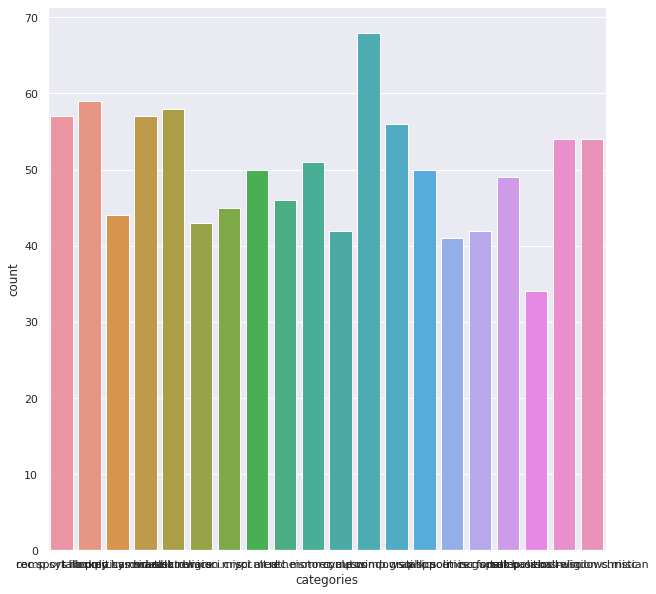

In [16]:
# count plot
import seaborn as sns
sns.set(rc={'figure.figsize':(10,10)})
sns.countplot(trainDF['categories'])

In [17]:
from sklearn.feature_extraction._stop_words import ENGLISH_STOP_WORDS
from nltk.corpus import stopwords
import string
# Stop words and special characters 
STOPLIST = set(stopwords.words('english') + list(ENGLISH_STOP_WORDS)) 
SYMBOLS = " ".join(string.punctuation).split(" ") + ["-", "...", "”", "”","''"]

In [18]:
# Data Cleaner and tokenizer
import spacy
from spacy.lang.en import English
from spacy.lang.en.examples import sentences #sample sentences
nlp = spacy.load('en_core_web_sm')
def tokenizeText(text):

    text = text.strip().replace("\n", " ").replace("\r", " ")
    text = text.lower()
    
    # tokens = parser(text)
    tokens = nlp(text)

    # print('Initial Tokens:', tokens)
    
    lemmas = []
    for tok in tokens:
        lemmas.append(tok.lemma_)
    tokens = lemmas
    # print('\nLemmatized Tokens:', tokens)

    
    # remove stop words and special charaters
    tokens = [tok for tok in tokens if tok.lower() not in STOPLIST]
    tokens = [tok for tok in tokens if tok not in SYMBOLS]
    tokens = [tok for tok in tokens if len(tok) >= 3]
    # print('\nStopword- and Special-Character Removed Tokens:', tokens)
    
    # remove remaining tokens that are not alphabetic
    tokens = [tok for tok in tokens if tok.isalpha()]
    
    # stemming of words
    #porter = PorterStemmer()
    #tokens = [porter.stem(word) for word in tokens]
    
    tokens = list(set(tokens)) #comment this if you want to keep the position of the words
    # print('\nFinal Tokens:', tokens)

    #return tokens
    return ' '.join(tokens[:])

In [20]:
# Data cleaning
trainDF['text_tokenized'] = trainDF['text'].apply(lambda x:tokenizeText(x))
trainDF.head()

,text,categories,text_tokenized
0,From: Mamatha Devineni Ratnam <mr47+@andrew.cm...,rec.sport.hockey,fan stat watch recent relief bad beat lose mel...
1,From: mblawson@midway.ecn.uoknor.edu (Matthew ...,comp.sys.ibm.pc.hardware,ram heaven recommendation lawson orchid exalt ...
2,From: hilmi-er@dsv.su.se (Hilmi Eren)\nSubject...,talk.politics.mideast,iran real regional sea intercept fabrication t...
3,From: guyd@austin.ibm.com (Guy Dawson)\nSubjec...,comp.sys.ibm.pc.hardware,feature multi real similar standard second cpu...
4,From: Alexander Samuel McDiarmid <am2o+@andrew...,comp.sys.mac.hardware,device modern understanding tape new samuel me...


In [21]:
# split the dataset into training and validation datasets 
train_x, valid_x, train_y, valid_y = model_selection.train_test_split(trainDF['text'], trainDF['categories'])


##Count Vectors

In [22]:
# Count Vectors as features
# create a count vectorizer object 
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(trainDF['text'])

# transform the training and validation data using count vectorizer object
xtrain_count =  count_vect.transform(train_x)
xvalid_count =  count_vect.transform(valid_x)

In [23]:
xtrain_count.shape

(750, 29511)

In [24]:
#reduce data dimension using PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2).fit(count_vect.transform(trainDF['text']).toarray())
data2D = pca.transform(count_vect.transform(trainDF['text']).toarray())

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


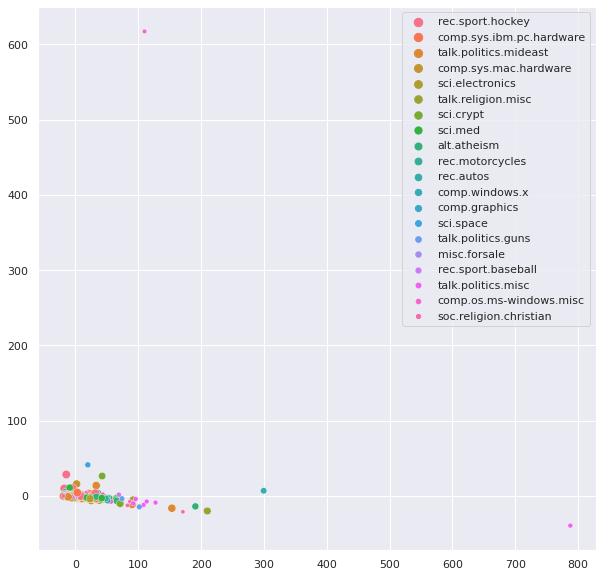

In [25]:
# plot the features
ax = sns.scatterplot(data2D[:,0], data2D[:,1], hue=trainDF['categories'].tolist(),size=trainDF['categories'].tolist(),palette="husl")

##TF-IDF Vectors

###word level tf-idf

In [26]:
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', stop_words = 'english', max_features=5000)
tfidf_vect.fit(trainDF['text'])

xtrain_tfidf =  tfidf_vect.transform(train_x)
xvalid_tfidf =  tfidf_vect.transform(valid_x)

In [27]:
tfidf_vect.transform(trainDF['text']).toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [28]:
trainDF['text']

0      From: Mamatha Devineni Ratnam <mr47+@andrew.cm...
1      From: mblawson@midway.ecn.uoknor.edu (Matthew ...
2      From: hilmi-er@dsv.su.se (Hilmi Eren)\nSubject...
3      From: guyd@austin.ibm.com (Guy Dawson)\nSubjec...
4      From: Alexander Samuel McDiarmid <am2o+@andrew...
                             ...                        
995    From: s872505@minyos.xx.rmit.OZ.AU (Stephen Bo...
996    From: astein@nysernet.org (Alan Stein)\nSubjec...
997    From: francis@ircam.fr (Joseph Francis)\nSubje...
998    From: carolan@owlnet.rice.edu (Bryan Carolan D...
999    From: Wayne Alan Martin <wm1h+@andrew.cmu.edu>...
Name: text, Length: 1000, dtype: object

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


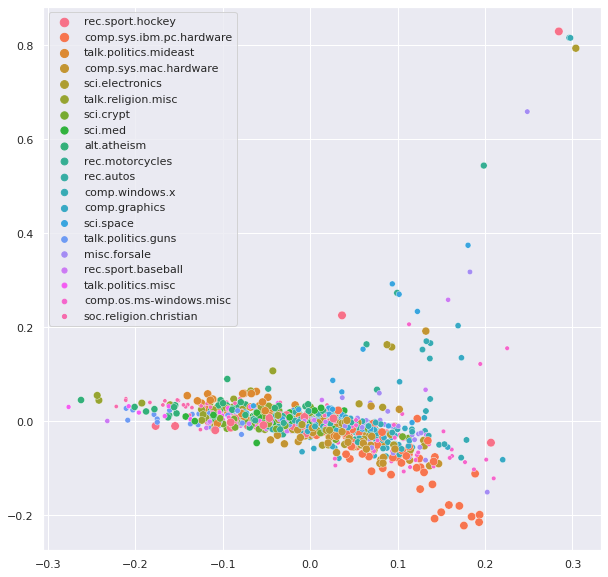

In [29]:
pca = PCA(n_components=2).fit(tfidf_vect.transform(trainDF['text']).toarray())
data2D = pca.transform(tfidf_vect.transform(trainDF['text']).toarray())
# plot the features
ax = sns.scatterplot(data2D[:,0], data2D[:,1],
hue=trainDF['categories'].tolist(),size=trainDF['categories'].tolist(),palette="husl")

###ngram level tf-idf

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


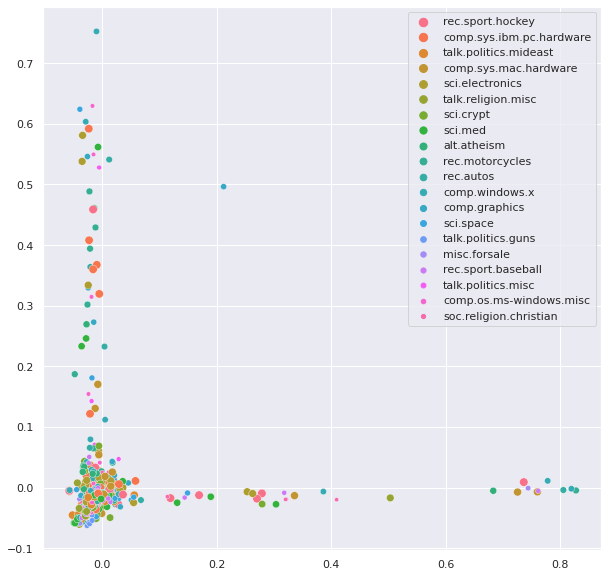

In [30]:
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,3), stop_words = 'english', max_features=5000)
tfidf_vect_ngram.fit(trainDF['text'])
xtrain_tfidf_ngram =  tfidf_vect_ngram.transform(train_x)
xvalid_tfidf_ngram =  tfidf_vect_ngram.transform(valid_x)
# plot the features
pca = PCA(n_components=2).fit(tfidf_vect_ngram.transform(trainDF['text']).toarray())
data2D = pca.transform(tfidf_vect_ngram.transform(trainDF['text']).toarray())
cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)
ax = sns.scatterplot(data2D[:,0], data2D[:,1],
hue=trainDF['categories'].tolist(),size=trainDF['categories'].tolist(),palette="husl")

###characters level tf-idf

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


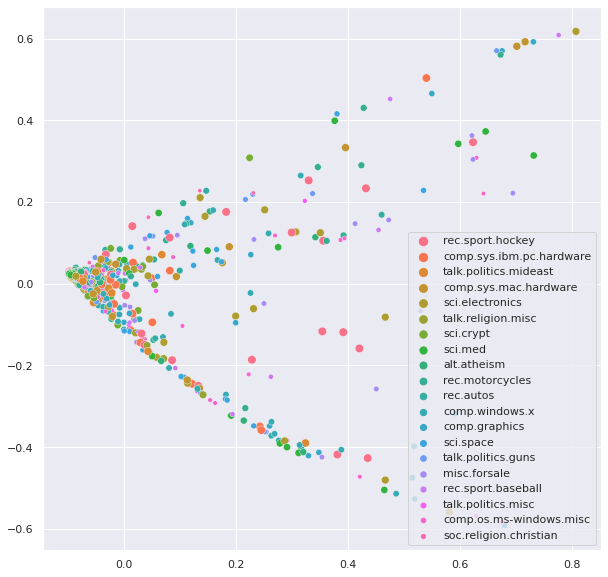

In [31]:
tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='char', max_features=5000)
tfidf_vect_ngram_chars.fit(trainDF['text'])
xtrain_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(train_x) 
xvalid_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(valid_x) 
# plot the features
pca = PCA(n_components=2).fit(tfidf_vect_ngram_chars.transform(trainDF['text']).toarray())
data2D = pca.transform(tfidf_vect_ngram_chars.transform(trainDF['text']).toarray())
ax = sns.scatterplot(data2D[:,0], data2D[:,1],
hue=trainDF['categories'].tolist(),size=trainDF['categories'].tolist(),palette="husl")

##HashingVectorizer

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


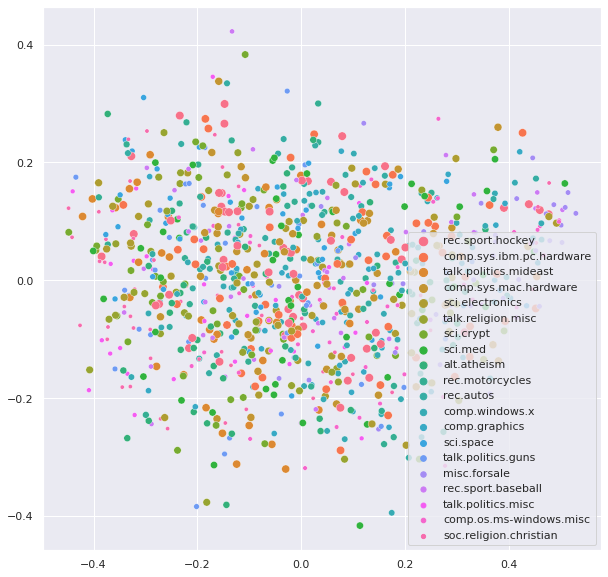

In [34]:
# getting train features
hash_vectorizer = HashingVectorizer(n_features=5000)
hash_vectorizer.fit(trainDF['text'])
xtrain_hash_vectorizer =  hash_vectorizer.transform(train_x) 
xvalid_hash_vectorizer =  hash_vectorizer.transform(valid_x)
# plot the features
pca = PCA(n_components=2).fit(hash_vectorizer.transform(trainDF['text']).toarray())
data2D = pca.transform(hash_vectorizer.transform(trainDF['text']).toarray())
cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)
ax = sns.scatterplot(data2D[:,0], data2D[:,1],
hue=trainDF['categories'].tolist(),size=trainDF['categories'].tolist(),palette="husl")

#Build the model

In [35]:
def train_model(classifier, feature_vector_train, label, feature_vector_valid, is_neural_net=False):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
    
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)
    
    if is_neural_net:
        predictions = predictions.argmax(axis=-1)
    
    return metrics.accuracy_score(predictions, valid_y)

#Naive Bayes

In [36]:
# Naive Bayes on Count Vectors
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_count, train_y, xvalid_count)
print("NB, Count Vectors: ", accuracy)

# Naive Bayes on Word Level TF IDF Vectors
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf, train_y, xvalid_tfidf)
print("NB, WordLevel TF-IDF: ", accuracy)

# Naive Bayes on Ngram Level TF IDF Vectors
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print("NB, N-Gram Vectors: ", accuracy)

# Naive Bayes on Character Level TF IDF Vectors
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars)
print("NB, CharLevel Vectors: ", accuracy)

NB, Count Vectors:  0.416
NB, WordLevel TF-IDF:  0.484
NB, N-Gram Vectors:  0.34
NB, CharLevel Vectors:  0.048


#Logistic Regression

In [37]:
# Linear Classifier on Count Vectors
accuracy = train_model(linear_model.LogisticRegression(solver="lbfgs",multi_class="auto",max_iter=4000), xtrain_count, train_y, xvalid_count)
print("LR, Count Vectors: ", accuracy)

# Linear Classifier on Word Level TF IDF Vectors
accuracy = train_model(linear_model.LogisticRegression(solver="lbfgs",multi_class="auto",max_iter=4000), xtrain_tfidf, train_y, xvalid_tfidf)
print("LR, WordLevel TF-IDF: ", accuracy)

# Linear Classifier on Ngram Level TF IDF Vectors
accuracy = train_model(linear_model.LogisticRegression(solver="lbfgs",multi_class="auto",max_iter=4000), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print("LR, N-Gram Vectors: ", accuracy)

# Linear Classifier on Character Level TF IDF Vectors
accuracy = train_model(linear_model.LogisticRegression(solver="lbfgs",multi_class="auto",max_iter=4000), xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars)
print("LR, CharLevel Vectors: ", accuracy)

# Linear Classifier on Hash Vectors
accuracy = train_model(linear_model.LogisticRegression(solver="lbfgs",multi_class="auto",max_iter=4000), xtrain_hash_vectorizer, train_y, xvalid_hash_vectorizer)
print("LR, Hash Vectors: ", accuracy)

LR, Count Vectors:  0.544
LR, WordLevel TF-IDF:  0.584
LR, N-Gram Vectors:  0.376
LR, CharLevel Vectors:  0.116
LR, Hash Vectors:  0.344


#Support Vector Classifier

In [45]:
# SVM Classifier on Count Vectors
accuracy = train_model(svm.LinearSVC(multi_class="ovr",max_iter=4000), xtrain_count, train_y, xvalid_count)
print("SVM, Count Vectors: ", accuracy)

# SVM Classifier on Word Level TF IDF Vectors
accuracy = train_model(svm.LinearSVC(multi_class="ovr",max_iter=4000), xtrain_tfidf, train_y, xvalid_tfidf)
print("SVM, WordLevel TF-IDF: ", accuracy)

# SVM Classifier on Ngram Level TF IDF Vectors
accuracy = train_model(svm.LinearSVC(multi_class="ovr",max_iter=4000), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print("SVM, N-Gram Vectors: ", accuracy)

# SVM Classifier on Character Level TF IDF Vectors
accuracy = train_model(svm.LinearSVC(multi_class="ovr",max_iter=4000), xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars)
print("SVM, CharLevel Vectors: ", accuracy)

# SVM Classifier on Hash Vectors
accuracy = train_model(svm.LinearSVC(multi_class="ovr",max_iter=4000), xtrain_hash_vectorizer, train_y, xvalid_hash_vectorizer)
print("SVM, Hash Vectors: ", accuracy)

SVM, Count Vectors:  0.608
SVM, WordLevel TF-IDF:  0.728
SVM, N-Gram Vectors:  0.484
SVM, CharLevel Vectors:  0.212
SVM, Hash Vectors:  0.624
